# Analise de Otimização


Esta parte do trabalho foi feita com o intuito de conseguir identificar melhores produtos para propormos soluções e melhorias no âmbito da sustentabilidade na Amazonia Legal. Primeiro, analisou-se a variação das areas florestais (Plantações, Vegetação nativa, entre outros) com o intuito de ver a evolução desses espaços ao longo do tempo, seja de forma quantitativa ou absoluta.

Depois, analisou-se o comportamento do rendimento médio ao longo dos anos baseado nos indicadores de produçao agricola. Diante disso, foi possivel analisar a relaçao do rendimento médio com a evoluçao das areas florestais e verificar o que ocasionou essas modificaçoes, caso elas existam.

Por fim, este notebook apresenta um exemplo feito para o municipio de Alta Floresta D'Oeste. Por consequinte, observou-se um pequena variação nas areas florestais em conjunto com um aumento significativo do rendimento médio e uma mudança na produção agricola. 

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importando bibliotecas que julgamos importantes

In [3]:
# Imports
!pip install matplotlib==3.1.3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 8.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Leitura dos arquivos CSV e XLSX usando pandas

In [5]:
# Lendo dados do censo
df_censo = pd.read_excel('/content/drive/MyDrive/Dados - GAMMA Challenge 2022/CENSO/Censo_municipal_estadual_nacional.xlsx',
                         sheet_name = 'MUN 91-00-10')
# Lendo dados do registro adm
df_reg_adm = pd.read_excel('/content/drive/MyDrive/Dados - GAMMA Challenge 2022/Registros Administrativos/dados_registros_administrativos_total_2012_2017.xlsx.xlsx'
                            , sheet_name = 'MUNICÍPIO')

# Lendo dados do censo
df_censo_leg = pd.read_excel('/content/drive/MyDrive/Dados - GAMMA Challenge 2022/CENSO/Censo_municipal_estadual_nacional.xlsx', sheet_name = 'Siglas')
df_reg_adm_leg = pd.read_excel('/content/drive/MyDrive/Dados - GAMMA Challenge 2022/Registros Administrativos/dados_registros_administrativos_total_2012_2017.xlsx.xlsx', sheet_name = 'LEGENDA')


In [6]:
#df_exportacoes =  pd.read_csv("/content/drive/MyDrive/Dados - GAMMA Challenge 2022/Exportacoes (COMEXSTAT)/exportacao_full.csv")

df_PAM_data =  pd.read_excel("/content/drive/MyDrive/Dados - GAMMA Challenge 2022/Producao Agricola Municipal (PAM)/PAM.xlsx"
                            , sheet_name = 'Dados')
df_PAM_dict =  pd.read_excel("/content/drive/MyDrive/Dados - GAMMA Challenge 2022/Producao Agricola Municipal (PAM)/PAM.xlsx"
                            , sheet_name = 'Dicionário')
df_PAM_extVar =  pd.read_excel("/content/drive/MyDrive/Dados - GAMMA Challenge 2022/Producao Agricola Municipal (PAM)/PAM.xlsx"
                            , sheet_name = 'Variáveis externas')

df_cover_biomas =  pd.read_csv("/content/drive/MyDrive/Dados - GAMMA Challenge 2022/Mapbiomas - Cobertura/mapbiomas_cover.csv")

In [7]:
df_cover_biomas.head()

,territory_id,municipality,state,year,x3_farming,x4_non_vegetated_area,x1_forest,x2_non_forest_natural_formation,x5_water,non_observed
0,1100015,Alta Floresta D'Oeste,RO,1985,48568.892517,210.477897,559194.592657,95175.289185,2795.436600,1.046006
1,1100015,Alta Floresta D'Oeste,RO,1986,53703.634674,237.870535,552899.558928,95728.845528,3374.779227,1.045971
2,1100015,Alta Floresta D'Oeste,RO,1987,58325.284347,244.609343,551223.232180,92834.982285,3317.016557,0.610151
3,1100015,Alta Floresta D'Oeste,RO,1988,69339.660163,244.609343,529076.777396,103668.301130,3615.602347,0.784483
4,1100015,Alta Floresta D'Oeste,RO,1989,73579.615082,254.761144,523968.748778,104688.599689,3453.138494,0.871675


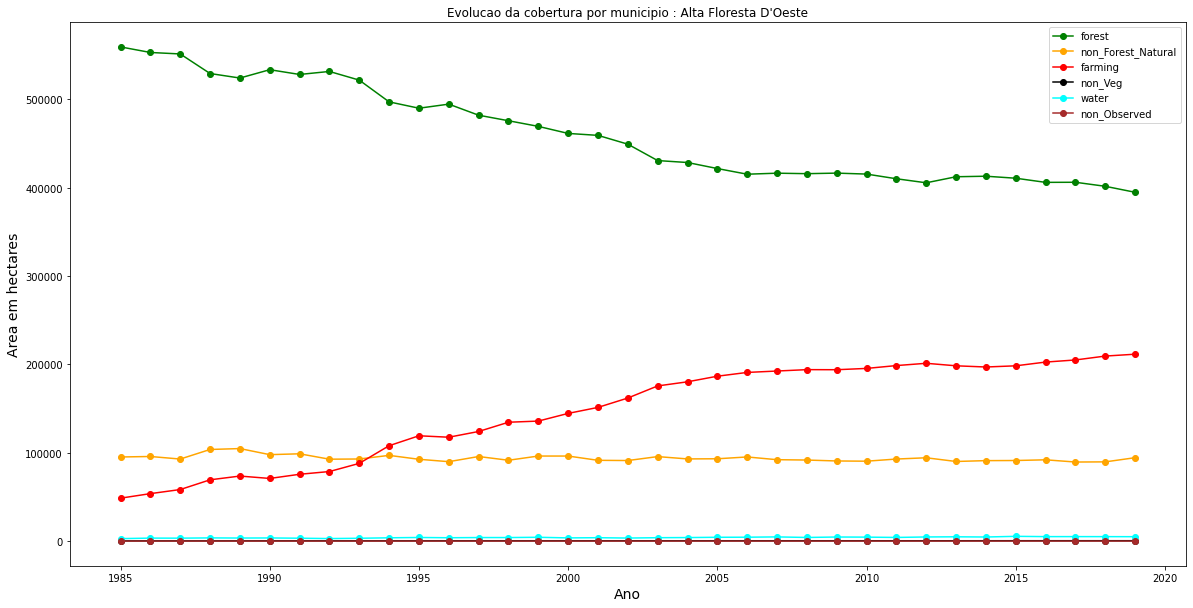

In [8]:
municipality = "Alta Floresta D'Oeste"
df = df_cover_biomas.copy()
objects =  pd.unique(df.year) 
df = df[(df.municipality == municipality)]
df = df[df.year.isin(objects) ]


forest = df['x1_forest']
non_Forest_Natural= df['x2_non_forest_natural_formation']
farming = df['x3_farming']
non_Veg = df['x4_non_vegetated_area']
water = df['x5_water']
non_Observed = df['non_observed']

plt.figure(figsize=(20, 10))

plt.title('Evolucao da cobertura por municipio : {}'.format(municipality))
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Area em hectares', fontsize=14)

plt.plot(objects,forest,label='forest', color='green', marker='o')
plt.plot(objects,non_Forest_Natural,label='non_Forest_Natural', color='orange', marker='o')
plt.plot(objects,farming,label='farming', color='red', marker='o')
plt.plot(objects,non_Veg,label='non_Veg', color='black', marker='o')
plt.plot(objects,water,label='water', color='cyan', marker='o')
plt.plot(objects,non_Observed,label='non_Observed', color='brown', marker='o')

plt.legend(loc="best")
plt.show()


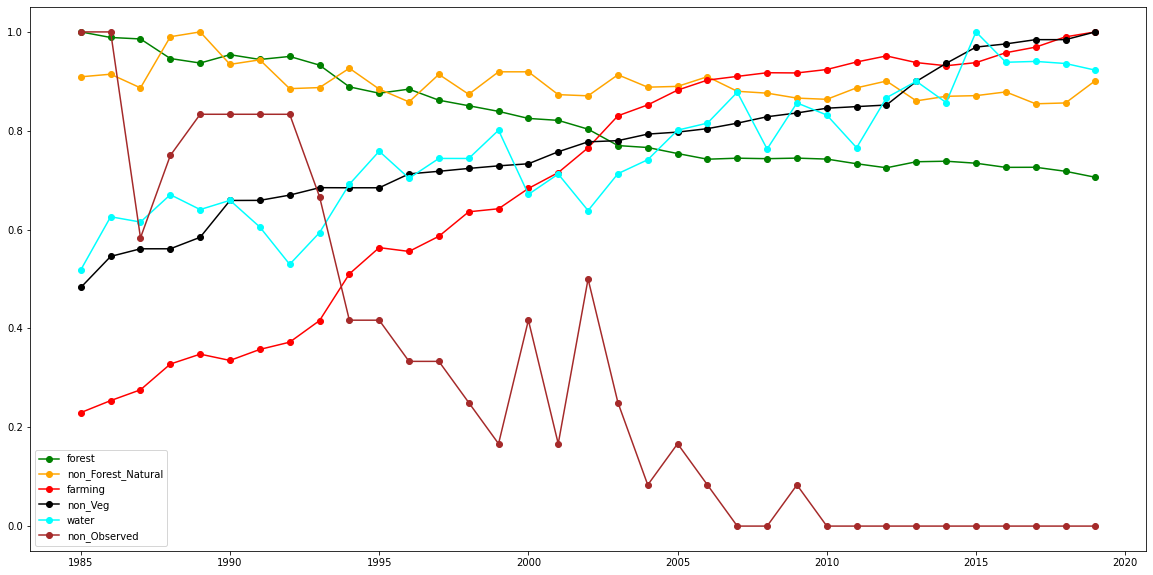

In [9]:

def maximum_absolute_scaling(df):
    # copy the dataframe
    df_scaled = df.copy()
    # apply maximum absolute scaling
    for column in df_scaled.columns:
        df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
    return df_scaled


municipality = "Alta Floresta D'Oeste"
df = df_cover_biomas.copy()
df = df[(df.municipality == municipality)]
df = df[df.year.isin(objects) ]
forest = maximum_absolute_scaling(df['x1_forest'].to_frame())
non_Forest_Natural=  maximum_absolute_scaling(df['x2_non_forest_natural_formation'].to_frame())
farming =  maximum_absolute_scaling(df['x3_farming'].to_frame())
non_Veg =  maximum_absolute_scaling(df['x4_non_vegetated_area'].to_frame())
water =  maximum_absolute_scaling(df['x5_water'].to_frame())
non_Observed =  maximum_absolute_scaling(df['non_observed'].to_frame())


plt.figure(figsize=(20, 10))

plt.plot(objects,forest,label='forest', color='green', marker='o')
plt.plot(objects,non_Forest_Natural,label='non_Forest_Natural', color='orange', marker='o')
plt.plot(objects,farming,label='farming', color='red', marker='o')
plt.plot(objects,non_Veg,label='non_Veg', color='black', marker='o')
plt.plot(objects,water,label='water', color='cyan', marker='o')
plt.plot(objects,non_Observed,label='non_Observed', color='brown', marker='o')


plt.legend(loc="best")
plt.show()


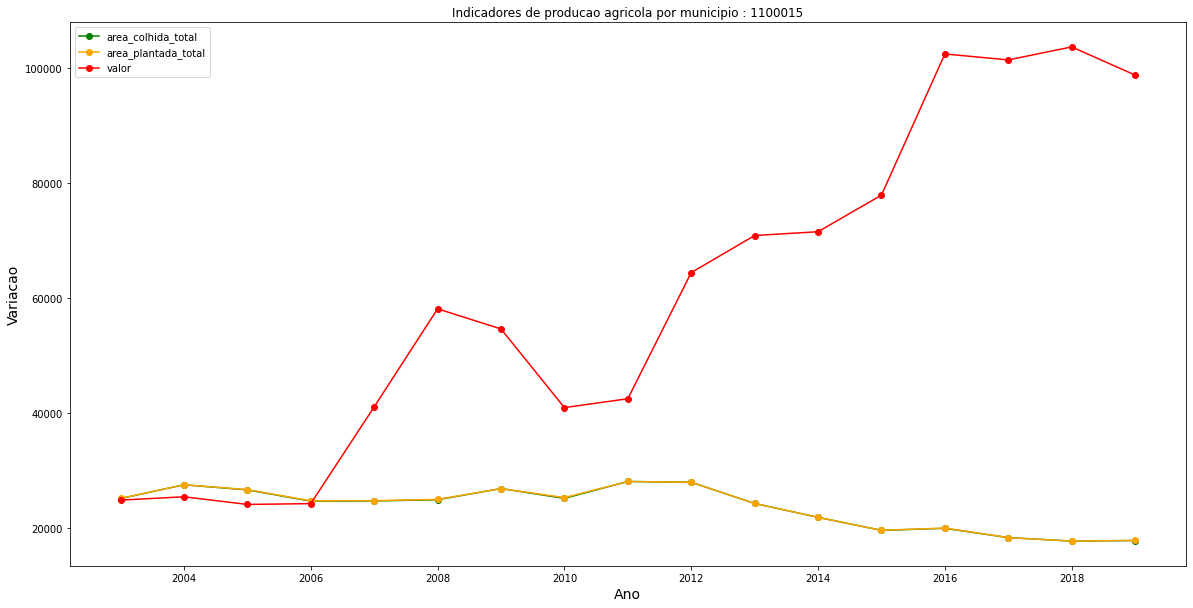

In [10]:
municipality = 1100015
df = df_PAM_data.copy()
objects =  pd.unique(df.ano) 
df = df[(df.geo_id == municipality)]
list_columns = ["ano","area_colhida_v0" ,"area_plantada_dest_colheita_v0", "valor_v0"]
df = df[list_columns]
area_Colhida = df['area_colhida_v0']
area_Plantada_Dest_Colheita= df['area_plantada_dest_colheita_v0']
valor = df['valor_v0']

plt.figure(figsize=(20, 10))

plt.title('Indicadores de producao agricola por municipio : {}'.format(municipality))
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Variacao', fontsize=14)


plt.plot(objects,area_Colhida,label='area_colhida_total', color='green', marker='o')
plt.plot(objects,area_Plantada_Dest_Colheita,label='area_plantada_total', color='orange', marker='o')
plt.plot(objects,valor,label='valor', color='red', marker='o')

plt.legend(loc="best")
plt.show()


       valor_v0  valor_v40112  valor_v40119  valor_v40122  valor_v40139  \
82373  103737.0        5201.0       11912.0        8501.0       71811.0   

       valor_v40141  others  
82373       71811.0  6312.0  


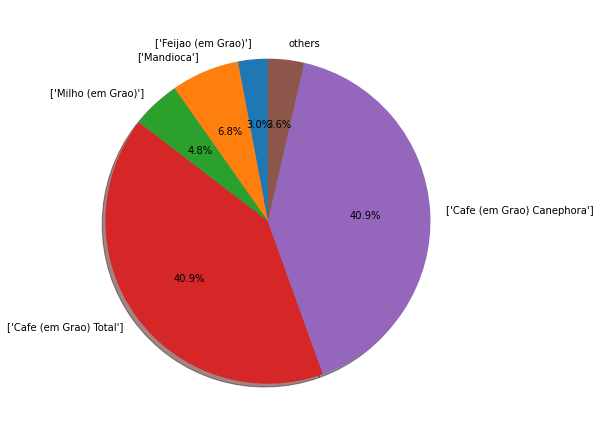

In [11]:
df_2 =  df_PAM_data.copy()
df_2 = df_2[(df_2.geo_id == municipality)]
df_2 = df_2[(df_2.ano == 2018)]
df_2 = df_2.fillna(0)
df_2 = df_2.loc[:,df_2.columns.str.startswith('valor')]



df_labels =  df_PAM_dict.copy()
df_labels = df_labels[['variable', 'label']]
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
df_2 = df_2.replace(0,np.nan).dropna(axis=1,how="all")
total_value = df_2['valor_v0'].values
irrelevant_profit = 0
for i in df_2:
    if  (df_2[i].values*100)/total_value < 5:
      irrelevant_profit += df_2[i].values
      df_2 = df_2.drop(columns=[i])
df_2["others"] = irrelevant_profit
print(df_2)
df_2 = df_2.drop(columns=['valor_v0'])
labels = df_2.columns.tolist() 


for i in labels:
    if i in df_labels['variable'].tolist():
        index = labels.index(str(i))
        labels[int(index)] = df_labels[df_labels.variable == i]['label'].values.tolist() 




fig1 = plt.figure(figsize=(10,6))
ax1 = fig1.add_axes((0,0,.5,1))
ax1.pie(df_2.values[0], labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.



plt.show()

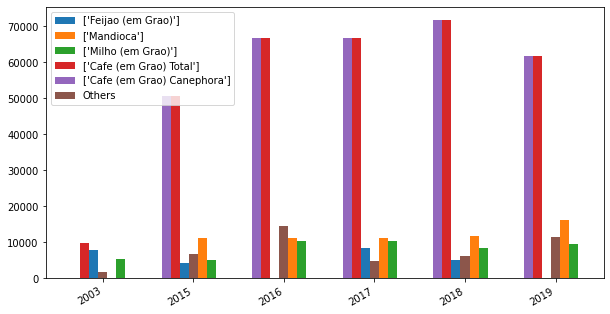

In [15]:




df_2 =  df_PAM_data.copy()
df_2 = df_2[(df_2.geo_id == municipality)]
years = [2003,2015,2016,2017,2018,2019]
df_2 = df_2.loc[df_2['ano'].isin(years)]
df_2 = df_2.fillna(0)
df_2 = df_2.loc[:,df_2.columns.str.startswith('valor')]

df_labels =  df_PAM_dict.copy()
df_labels = df_labels[['variable', 'label']]
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
df_2 = df_2.replace(0,np.nan).dropna(axis=1,how="all")
total_value = df_2['valor_v0'].values
df_2 = df_2.drop(columns=['valor_v0'])
row_number = 0
df_3 = []


for row in df_2.iterrows():
  irrelevant_profit = 0
  column_count = 0
  for i in row[-1]:
    if  ((i*100)/total_value[row_number]) < 5:
          irrelevant_profit += i
          df_2.iloc[row_number][column_count] = 0
    column_count +=1
  df_3.append(irrelevant_profit)
  row_number = row_number + 1
df_2["Others"] = df_3
df_2 = df_2.fillna(0)



width=0.1
fig = plt.figure(figsize = (10, 5))
x = np.arange(len(years))


visualization_df = pd.DataFrame()
for row in df_2.iterrows():
  teste = row[1][ row[1] != 0 ]
  labels = teste.index.tolist()


  for i in labels:
    if i in df_labels['variable'].tolist():
        index = labels.index(str(i))
        labels[int(index)] = df_labels[df_labels.variable == i]['label'].values.tolist()
  result = teste.tolist()
  Original_list = [['Feijao (em Grao)'], ['Mandioca'], ['Milho (em Grao)'], ['Cafe (em Grao) Total'], ['Cafe (em Grao) Canephora'], 'Others']

  for i in range(0,len(Original_list)) :
    if labels[i] != Original_list[i]: 
      result.insert(i, 0)
      labels.insert(i, Original_list[i])

  visualization_df = pd.concat(  [visualization_df, pd.Series(result)] , ignore_index = True, axis = 1)

  
visualization_df = visualization_df.T



plt.bar(x - width,visualization_df[0], width)
plt.bar(x + width,visualization_df[1], width)
plt.bar(x + 2*width ,visualization_df[2], width)
plt.bar(x - 2*width, visualization_df[3], width)
plt.bar(x - 3*width, visualization_df[4], width)
plt.bar(x,visualization_df[5], width)


plt.xticks([0,1,2,3,4,5], years, rotation=30, horizontalalignment='right')
plt.legend(labels, loc='upper left')

plt.show()
